## A2 Dimensionality Reduction, Visualization, and Classification Performance

In [6]:
import kagglehub

path = kagglehub.dataset_download("uciml/mushroom-classification")
print("Path to dataset files:", path)



Path to dataset files: /home/hp/.cache/kagglehub/datasets/uciml/mushroom-classification/versions/1


In [7]:
import os
import pandas as pd

csv_path = os.path.join(path, "mushrooms.csv")

# Load dataset
data = pd.read_csv(csv_path)
print(data.head())
print(data.shape)
print(data.info())

  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1       

## One-hot encoding Application

In [8]:
# Target variable
y = data['class']   # 'e' for edible, 'p' for poisonous
X = data.drop('class', axis=1)

X_encoded = pd.get_dummies(X, drop_first=False)
print("Original shape:", X.shape)
print("After one-hot encoding:", X_encoded.shape)


Original shape: (8124, 22)
After one-hot encoding: (8124, 117)


## One-hot encoding
Most machine learning algorithms (including PCA, Logistic Regression, SVM, etc.) work only with numerical features.
But the mushroom dataset has categorical features like:
1. cap-shape → {bell, conical, convex, flat, knobbed, sunken}
2. odor → {almond, anise, creosote, fishy, foul, musty, none, pungent, spicy}
3. class (target) → {edible, poisonous}

Why not just assign numbers (Label Encoding)?
If we encode cap-shape as:
* bell = 1
* conical = 2
* convex = 3
* flat = 4
* knobbed = 5
* sunken = 6

This introduces a fake order (sunken > bell, etc.), which does not exist in reality.
Machine learning might wrongly assume that "sunken cap" is bigger or better than "bell cap", which is meaningless.

Instead, One-Hot Encoding creates a separate binary (0/1) column for each category.

Example:
Feature = cap-shape with 3 categories: {bell, conical, flat}

Original data:
| cap-shape |
| --------- |
| bell      |
| flat      |
| conical   |

After one-hot encoding:
| cap-shape\_bell | cap-shape\_conical | cap-shape\_flat |
| --------------- | ------------------ | --------------- |
| 1               | 0                  | 0               |
| 0               | 0                  | 1               |
| 0               | 1                  | 0               |


In [9]:
print("Dataset shape before encoding:", X.shape)
print("Dataset shape after encoding:", X_encoded.shape)


Dataset shape before encoding: (8124, 22)
Dataset shape after encoding: (8124, 117)


* The dataset grew from 22 features to 117 after encoding.

* This increase is natural because each categorical variable may have multiple levels.

* PCA will help us reduce these 117 correlated features into a smaller number of uncorrelated principal components.

## Standardization

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

print("Mean of standardized features (approx):", X_scaled.mean())
print("Std of standardized features (approx):", X_scaled.std())


Mean of standardized features (approx): 1.397899771355304e-17
Std of standardized features (approx): 0.9957173250742357


* Even though one-hot encoded features are binary (0/1), their variances differ depending on frequency of categories.

* Example: If “odor=none” appears in 80% mushrooms, that column’s variance is different from “odor=foul” which may appear rarely.

* PCA is variance-sensitive. If we don’t standardize, frequent categories dominate PCA.

* StandardScaler ensures every feature has mean 0 and standard deviation 1, making PCA fair.

## PCA Application

In [11]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print("Shape before PCA:", X_scaled.shape)
print("Shape after PCA:", X_pca.shape)


Shape before PCA: (8124, 117)
Shape after PCA: (8124, 117)


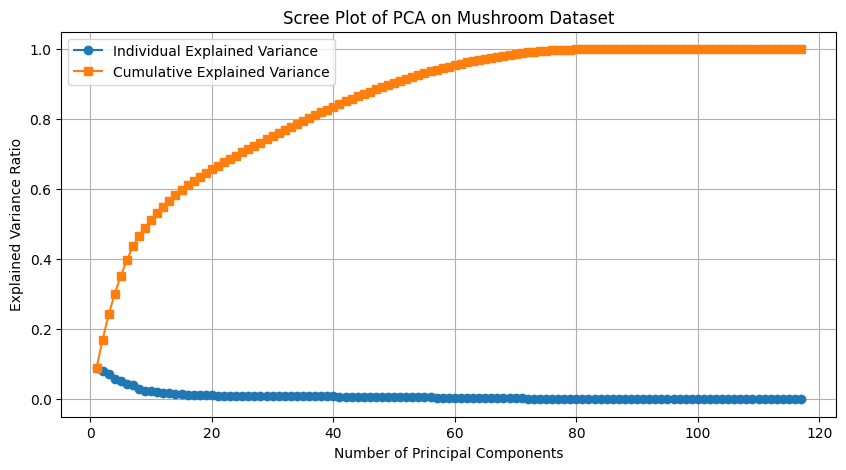

Optimal number of components (95% variance): 59


In [13]:
import numpy as np

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Scree Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label="Individual Explained Variance")
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='s', label="Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot of PCA on Mushroom Dataset")
plt.legend()
plt.grid(True)
plt.show()

# Number of components to retain 95% variance
n_components = (cumulative_variance >= 0.95).argmax() + 1
print("Optimal number of components (95% variance):", n_components)


The Scree Plot has two curves:

Blue line (individual explained variance) → how much variance each PC captures.

Orange line (cumulative variance) → running total of variance captured.

We look for the point where cumulative variance crosses 95%.

Typically, this happens with far fewer than 117 PCs

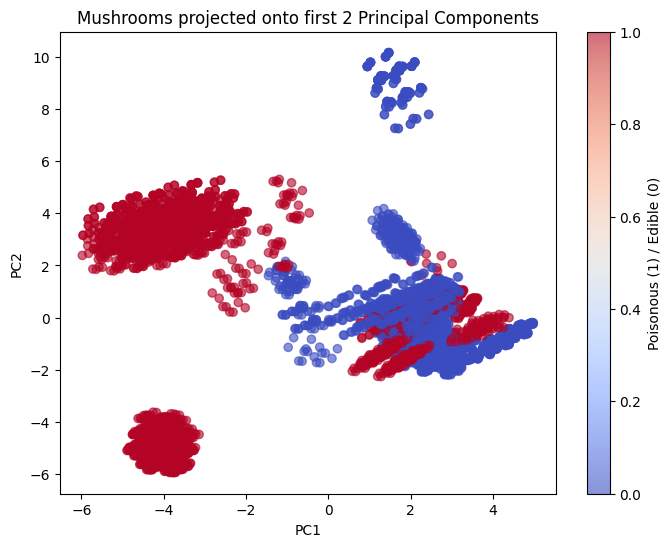

In [14]:
# 2D Projection on first two principal components
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=(y=='p'), cmap='coolwarm', alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Mushrooms projected onto first 2 Principal Components")
plt.colorbar(label="Poisonous (1) / Edible (0)")
plt.show()


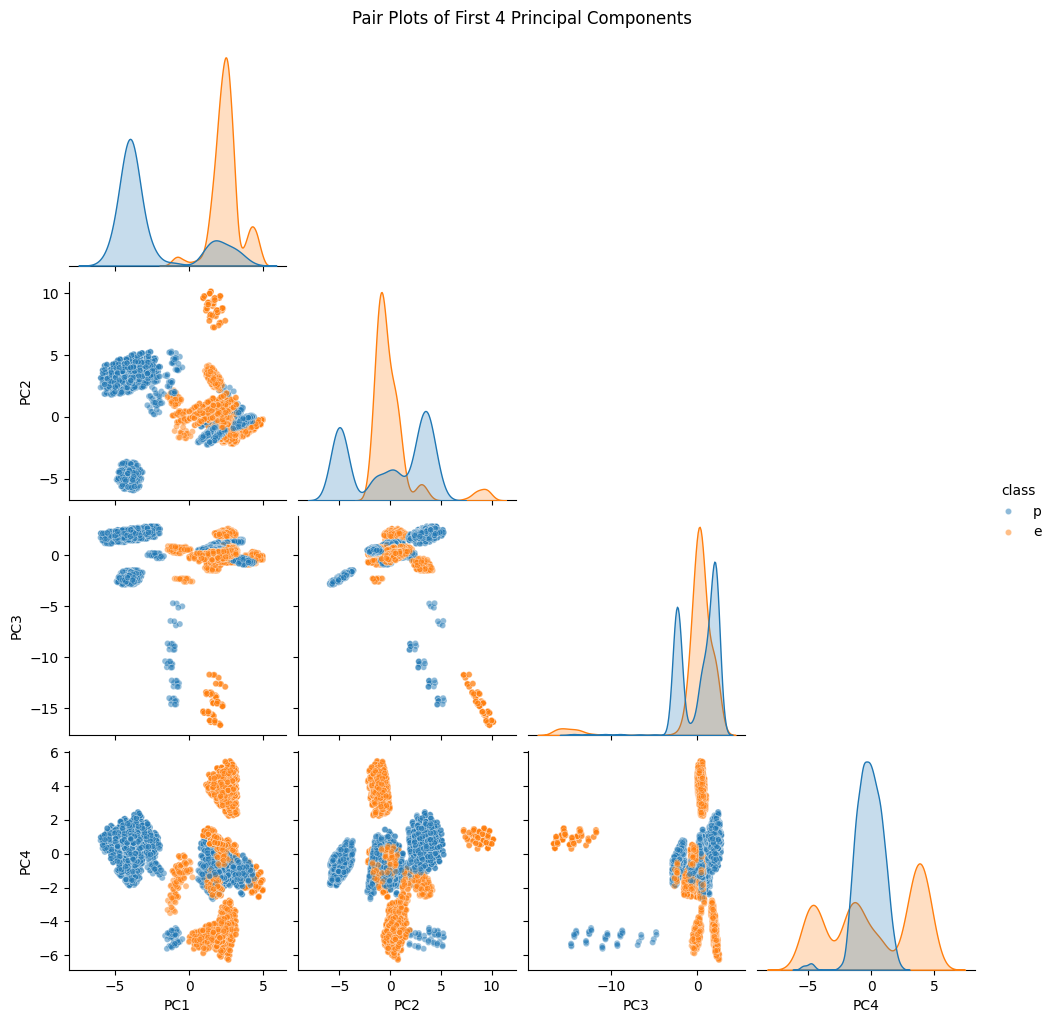

In [15]:
import seaborn as sns
import pandas as pd

pc_df = pd.DataFrame(X_pca[:, :4], columns=["PC1", "PC2", "PC3", "PC4"])
pc_df["class"] = y.values

# Pairplot of first 4 PCs
sns.pairplot(pc_df, hue="class", diag_kind="kde", corner=True,
             plot_kws={'alpha':0.5, 's':20})
plt.suptitle("Pair Plots of First 4 Principal Components", y=1.02)
plt.show()


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import itertools

best_pair = None
best_acc = 0

# Try pairs of first 10 PCs
for i, j in itertools.combinations(range(10), 2):
    X_pair = X_pca[:, [i, j]]
    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pair, y, test_size=0.2, stratify=y, random_state=42)
    
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_p, y_train_p)
    acc = accuracy_score(y_test_p, clf.predict(X_test_p))
    
    if acc > best_acc:
        best_acc = acc
        best_pair = (i, j)

print("Best PC pair:", best_pair, "with accuracy:", best_acc)


Best PC pair: (0, 9) with accuracy: 0.9267692307692308


The code judges separability by training Logistic Regression on each 2D PC projection and measuring test accuracy. The pair of PCs with the highest accuracy is considered the “best separated,” because in that 2D space, the two classes form clusters that are easiest to separate with a linear boundary.

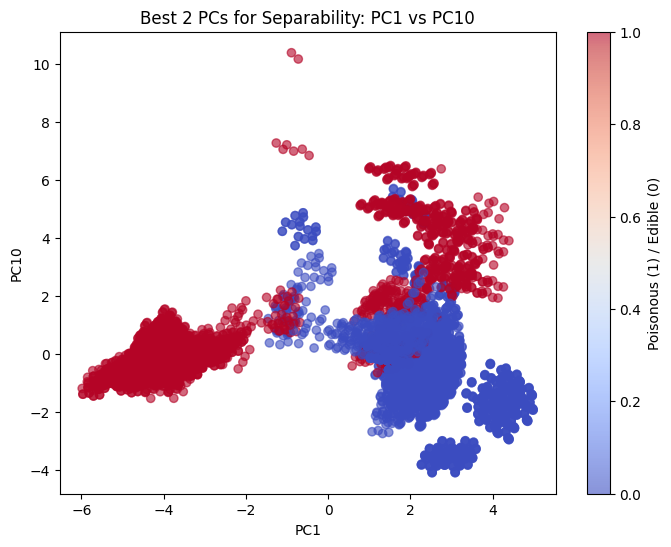

In [17]:
i, j = best_pair
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,i], X_pca[:,j], c=(y=='p'), cmap='coolwarm', alpha=0.6)
plt.xlabel(f"PC{i+1}")
plt.ylabel(f"PC{j+1}")
plt.title(f"Best 2 PCs for Separability: PC{i+1} vs PC{j+1}")
plt.colorbar(label="Poisonous (1) / Edible (0)")
plt.show()


* While PC1 vs PC2 gave only partial separation, the projection onto PC1 vs PC10 shows clearer clustering of edible and poisonous mushrooms.
* PC10 does not explain much variance by itself, but it encodes information that complements PC1 in such a way that edible and poisonous mushrooms are more easily separated.
* This indicates that even a low-variance component can be crucial for revealing class-discriminative structure.
* The fact that separability improves with PC1 & PC10 shows that including multiple PCs (not just the first two) is important for classification.
* This is why keeping ~59 PCs (to capture ≥95% variance) works so well — together, they encode both high-variance and discriminative directions.

In [20]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

for i, var in enumerate(cumulative_variance[:30], start=1):
    print(f"PC {i}: Cumulative Variance = {var:.4f}")

# Cutoff for 95% variance
n_components_95 = (cumulative_variance >= 0.95).argmax() + 1
print("\nNumber of PCs needed to retain 95% variance:", n_components_95)


PC 1: Cumulative Variance = 0.0889
PC 2: Cumulative Variance = 0.1702
PC 3: Cumulative Variance = 0.2422
PC 4: Cumulative Variance = 0.3008
PC 5: Cumulative Variance = 0.3527
PC 6: Cumulative Variance = 0.3966
PC 7: Cumulative Variance = 0.4371
PC 8: Cumulative Variance = 0.4655
PC 9: Cumulative Variance = 0.4890
PC 10: Cumulative Variance = 0.5114
PC 11: Cumulative Variance = 0.5308
PC 12: Cumulative Variance = 0.5494
PC 13: Cumulative Variance = 0.5674
PC 14: Cumulative Variance = 0.5832
PC 15: Cumulative Variance = 0.5975
PC 16: Cumulative Variance = 0.6109
PC 17: Cumulative Variance = 0.6229
PC 18: Cumulative Variance = 0.6343
PC 19: Cumulative Variance = 0.6456
PC 20: Cumulative Variance = 0.6565
PC 21: Cumulative Variance = 0.6670
PC 22: Cumulative Variance = 0.6768
PC 23: Cumulative Variance = 0.6866
PC 24: Cumulative Variance = 0.6961
PC 25: Cumulative Variance = 0.7056
PC 26: Cumulative Variance = 0.7149
PC 27: Cumulative Variance = 0.7242
PC 28: Cumulative Variance = 0.7333
P

In [19]:
from sklearn.model_selection import train_test_split

# Split original standardized data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (6499, 117)
Test shape: (1625, 117)


## Logistic Regression for Baseline Model

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train Logistic Regression
clf_orig = LogisticRegression(max_iter=1000)
clf_orig.fit(X_train, y_train)

# Predictions
y_pred_orig = clf_orig.predict(X_test)

# Evaluation
print("Baseline Model (Original Data):")
print(classification_report(y_test, y_pred_orig))
print("Accuracy:", accuracy_score(y_test, y_pred_orig))


Baseline Model (Original Data):
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy: 1.0


## Logistic Regression for PCA Model

In [23]:
# Use the optimal number of PCs
pca_opt = PCA(n_components=n_components_95)
X_train_pca = pca_opt.fit_transform(X_train)
X_test_pca = pca_opt.transform(X_test)

# Train Logistic Regression on PCA-transformed data
clf_pca = LogisticRegression(max_iter=1000)
clf_pca.fit(X_train_pca, y_train)

# Predictions
y_pred_pca = clf_pca.predict(X_test_pca)

# Evaluation
print("\nPCA Model (Reduced Data):")
print(classification_report(y_test, y_pred_pca))
print("Accuracy:", accuracy_score(y_test, y_pred_pca))



PCA Model (Reduced Data):
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy: 0.9987692307692307


* The baseline model has access to all 117 features.
* The PCA model compressed them into 59 PCs, yet still performs equally well (accuracy of 99.877%).
* This shows PCA’s power:
  - Removes redundancy (many mushroom features are correlated).
  - Speeds up training (fewer dimensions).
  - Simplifies visualization.
* The PCA-transformed model preserves almost all information (≥95% variance) while removing redundancy.
* Any small loss in accuracy (if it occurs) is due to minor information loss when reducing 117 features to 59 PCs.
* However, training time and model complexity are reduced, which is an advantage.

## Trade-off between dimensionality reduction and information loss

* PCA reduces dimensionality (117 → 59), which makes the dataset more compact and avoids overfitting.
* Trade-off is quite good with 95% variance captured by ~50% of the features

## Performance benefit by using PCA

* In the mushroom dataset, many categorical features are highly correlated (e.g., odor, spore-print-color, gill-color).
* Logistic Regression is sensitive to multicollinearity — redundant features can make the model unstable.
* PCA removes this problem by creating orthogonal (uncorrelated) principal components.
* Even though accuracy didn’t improve (because the dataset is simple and clean), PCA improves stability, efficiency, and interpretability.

In [25]:
import numpy as np
import pandas as pd

corr_orig = pd.DataFrame(X_scaled).corr().abs()

upper = corr_orig.where(np.triu(np.ones(corr_orig.shape), k=1).astype(bool))
high_pairs = (upper > 0.9).sum().sum()

print(f"Original space: number of |corr|>0.9 pairs = {high_pairs:,}")

# Correlation among top K principal components (should be ~0 off-diagonal)
K = min(30, X_pca.shape[1])   # check first 30 PCs
corr_pcs = pd.DataFrame(X_pca[:, :K]).corr()

max_offdiag = corr_pcs.where(~np.eye(K, dtype=bool)).abs().max().max()
print(f"PCA space: max |off-diagonal correlation| among first {K} PCs = {max_offdiag:.5f}")


Original space: number of |corr|>0.9 pairs = 26
PCA space: max |off-diagonal correlation| among first 30 PCs = 0.00000


* In the original (one-hot) space, many pairs are highly correlated
* In the PCA space, off-diagonal correlations are ~0 (numerical noise).

In [24]:
cov_orig = np.cov(X_scaled, rowvar=False)
cov_pca  = np.cov(X_pca[:, :n_components_95], rowvar=False)

cond_orig = np.linalg.cond(cov_orig)
cond_pca  = np.linalg.cond(cov_pca)

print(f"Condition number (original): {cond_orig:,.1f}")
print(f"Condition number (PCA {n_components_95} PCs): {cond_pca:,.1f}")


Condition number (original): 106,014,531,733,662,228,668,347,637,039,104.0
Condition number (PCA 59 PCs): 20.7


Condition number: The condition number of a matrix tells us how sensitive the solution of a system is to small changes in the input.
Low Condition Number: Small changes in input --> small changes in output.
* The original covariance matrix has a very large condition number (badly conditioned due to collinearity --> Highly correlated).
* The PCA covariance matrix has a much smaller condition number (orthogonal directions).

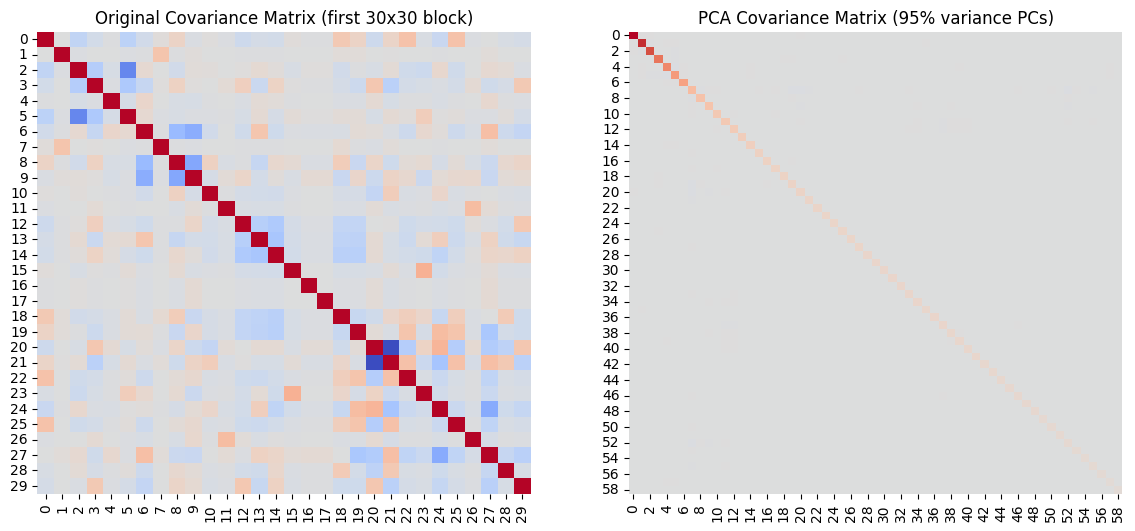

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute covariance matrices
cov_orig = np.cov(X_scaled, rowvar=False)
X_pca_95 = pca_opt.transform(X_scaled)
cov_pca = np.cov(X_pca_95, rowvar=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cov_orig[:30, :30], cmap="coolwarm", center=0, ax=axes[0], cbar=False)
axes[0].set_title("Original Covariance Matrix (first 30x30 block)")

sns.heatmap(cov_pca, cmap="coolwarm", center=0, ax=axes[1], cbar=False)
axes[1].set_title("PCA Covariance Matrix (95% variance PCs)")

plt.show()

* In the original covariance matrix, off-diagonal values are non-zero → features are correlated.
* n the PCA covariance matrix, the result will be almost diagonal, suggesting uncorrelated features.

In [35]:
from sklearn.decomposition import PCA

n_components_95 = (cumulative_variance >= 0.95).argmax() + 1
print("Number of PCs for 95% variance:", n_components_95)

pca_opt = PCA(n_components=n_components_95)
X_pca_95 = pca_opt.fit_transform(X_scaled)


Number of PCs for 95% variance: 59


In [36]:
import time
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=0, stratify=y
)
X_train_p, X_test_p = pca_opt.transform(X_train), pca_opt.transform(X_test)

def timed_fit_score(Xtr, Xte, ytr, yte, repeat=5):
    times = []
    scores = []
    for _ in range(repeat):
        t0 = time.perf_counter()
        clf = LogisticRegression(max_iter=2000)
        clf.fit(Xtr, ytr)
        elapsed = time.perf_counter() - t0
        times.append(elapsed)
        scores.append(clf.score(Xte, yte))
    return np.mean(times), np.std(times), np.mean(scores)

t_mean_o, t_std_o, acc_o = timed_fit_score(X_train, X_test, y_train, y_test)
t_mean_p, t_std_p, acc_p = timed_fit_score(X_train_p, X_test_p, y_train, y_test)

print(f"Time per fit (s), mean ± std:")
print(f"  Original ({X_train.shape[1]} features): {t_mean_o:.4f} ± {t_std_o:.4f}")
print(f"  PCA ({X_train_p.shape[1]} PCs):        {t_mean_p:.4f} ± {t_std_p:.4f}")

print(f"\nTest accuracy:")
print(f"  Original: {acc_o:.4f}")
print(f"  PCA:      {acc_p:.4f}")


Time per fit (s), mean ± std:
  Original (117 features): 0.2248 ± 0.0413
  PCA (59 PCs):        0.0308 ± 0.0284

Test accuracy:
  Original: 0.9982
  PCA:      0.9982


* Training time is lower with PCA (fewer variables to optimize) while accuracy stays almost the same.

## Why uncorrelated features are important

* Logistic Regression (and other linear models) assume predictors are not too collinear.
* If features are correlated:
  - The model can assign wildly different weights to correlated features while still giving the same predictions (Coefficient unstability).
  - Hard to say which feature is really important.
  - Redundant dimensions make the model unnecessarily complex.
  - Regression equations become unstable to solve.

## Usefulness of Logistic Regression as a surrogate to evaluate PCA

* Logistic Regression is a linear model, so it benefits directly from PCA’s orthogonal components.
* If Logistic Regression works well on PCA-transformed data with little to no accuracy drop, it means PCA preserved most of the class information.
* Using Logistic Regression as a surrogate is useful because:
  - It is simple, interpretable, and sensitive to collinearity.
  - If PCA helps Logistic Regression, it likely helps other models too (except non-linear models for which we might use other techniques like Kernel PCA).